In [1]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
help(damask)

Help on package damask:

NAME
    damask - Tools for managing DAMASK simulations.

PACKAGE CONTENTS
    _colormap
    _config
    _configmaterial
    _crystal
    _geomgrid
    _grid
    _loadcasegrid
    _orientation
    _result
    _rotation
    _table
    _typehints
    _vtk
    _yaml
    grid_filters
    mechanics
    seeds
    solver (package)
    tensor
    util

DATA
    name = 'damask'
    version = '3.0.1'

VERSION
    3.0.1

FILE
    /home/snkr/.local/lib/python3.10/site-packages/damask/__init__.py




In [4]:
resultfile_path = 'reference/10grains_voronoi_2x5x1_tensionX_rotation_z45_material_fullfield_6ferrite_4martensite.hdf5'

In [11]:
result = damask.Result(resultfile_path)
# result.add_stress_Cauchy()

postprossecing_dir = Path(resultfile_path).stem
# result.export_simulation_setup(target_dir=Path(resultfile_path).stem)
vti_path = list(Path(postprossecing_dir).glob("*.vti"))[0]
grid = damask.GeomGrid.load(vti_path)
grid

cells:  2 × 5 × 1
size:   2e-05 × 5e-05 × 1e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 10

# Example: Stress-strain curve for tensionX

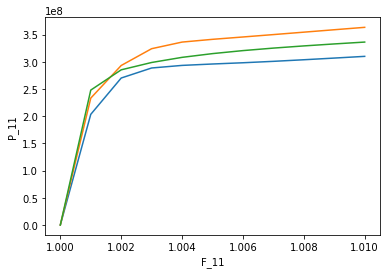

In [12]:
grains = [0,1,2]
# loop over all increments and store P(1,1) per grain and avg(F(1,1))
data = {g:pd.DataFrame() for g in grains}
for inc in result.get(['F','P']).values():
    P = inc['P']
    F = inc['F']
    for g in grains:
        points = grid.material.flatten(order='F')==g
        P_11 = P[points,0,0].flatten()
        F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
        x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
        data[g] = pd.concat((data[g],x),ignore_index=True)
for g in grains:
   plot = sns.lineplot(y='P_11',x='F_11',data=data[g])

fig = plot.get_figure()

# Example: Stress-Strain Density plot for each grain 

In [17]:
result = damask.Result(resultfile_path)
last_inc = result.view(increments=-1)
last_inc = result.view(homogenizations=False)
last_inc
df = pd.DataFrame({'F_11':last_inc.get('F')[:,0,0],
                   'P_11':last_inc.get('P')[:,0,0]})
# _ = df.plot.hexbin(x='F_11',y='P_11',gridsize=20,
#                    cmap=damask.Colormap.from_predefined('strain'))

TypeError: unhashable type: 'slice'

# Example: r-value calculation

In [1]:
result = damask.Result(resultfile_name)
result.add_strain('F_p','U')
result.add_equivalent_Mises('epsilon_U^0.0(F_p)')
epsilon_avg = np.array([np.average(eps,0) for eps in result.get('epsilon_U^0.0(F_p)').values()])
r = epsilon_avg[:,1,1]/epsilon_avg[:,2,2]
s = np.array([np.average(strain) for strain in result.get('epsilon_U^0.0(F_p)_vM').values()])
plt.plot(s[10:],r[10:])
plt.ylabel('r-value')
plt.xlabel('plastic vM strain')
plt.axis([0, 0.2, 0, 1])
plt.show()